# Initialization

In [2]:
# general
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.manifold import TSNE,MDS
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Load data

In [107]:
############################################
# Adjustments go here 
comp_file = "amines-PCA" # name of excel file
comp_sheet = "Sheet1"# name of the sheet

num_par = 26 # number of descriptors
comp_num_samples = 70  # number of samples (molecules)

y_label_col_comp = 0 # 0-indexed number of the column with the names of your samples
par_start_col = 1 # 0-indexed number of the first column containing descriptors
############################################

compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,
                        nrows=comp_num_samples+1,usecols=num_par+par_start_col-1)
compinp.index = compinp.index.map(str)

xlabelrow = True
verbose = True

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]
y_labels=y_labels_comp

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))

# Descriptor scaling

scaler = StandardScaler()    
X_all_sc = scaler.fit_transform(X_all)

if verbose:
    print("Shape X (all): {}".format(X_all.shape))
    print("First X cell: {}".format(X_all[0,0]))
    print("Last X cell:  {}".format(X_all[-1,-1]))
    print("Last label comp: {}".format(y_labels_comp[-1]))

Shape X (all): (70, 26)
First X cell: 1.917273382149343
Last X cell:  1.25741401817031
Last label comp: tBuNH2_1


# PC space

percentage of explained variance per principal component
PC1 50.7
PC2 14.1
PC3 12.3


<IPython.core.display.Javascript object>


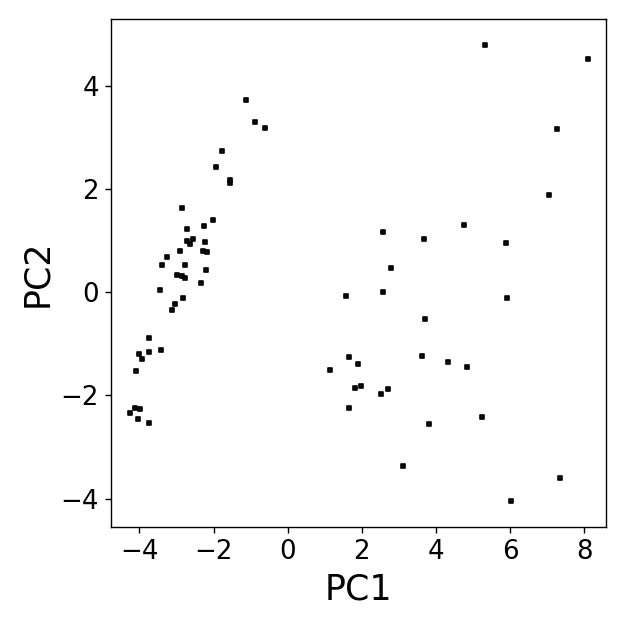

In [110]:
############################################
# how many principal components do you want to consider for the following analyses. 
# use the second line to obtain all principal components (recommended as a first pass to determine the optimal number of PC based on the explained variance)
pca = PCA(n_components=3) 
# pca = PCA() 

# PC plot: which principal components are plotted (start at 1)
f_ind_1 = 1 
f_ind_2 = 2

# the plot limits below might need adjustments if necessary
############################################

f_ind_1,f_ind_2 = f_ind_1-1,f_ind_2-1 # change numbers to 0-indexed

pca.fit(X_all_sc)
X_all_pca = pca.transform(X_all_sc)

pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
V = pca.components_

print("percentage of explained variance per principal component")
for i,j in enumerate(pca_score):
    print(f"PC{i+1} {j*100:.1f}")

# Plot details
# define plot limits. Might need changes based on the absolute PC values.
x_min, x_max = X_all_pca[:, f_ind_1].min() - .5, X_all_pca[:, f_ind_1].max() + .5
y_min, y_max = X_all_pca[:, f_ind_2].min() - .5, X_all_pca[:, f_ind_2].max() + .5

# optional cropping
X_all_pca_c = X_all_pca[(X_all_sc[:,f_ind_2]>y_min)&(X_all_pca[:,f_ind_2]<y_max)]

plt.figure(figsize=(5,5))
extent = [x_min,x_max,y_min,y_max]
 
plt.scatter(X_all_pca_c[:,f_ind_1], X_all_pca_c[:,f_ind_2],color="black",marker="s",alpha=".95",s=5.00) 

plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(f"PC{f_ind_1+1}",fontsize=20)
plt.ylabel(f"PC{f_ind_2+1}",fontsize=20)
# plt.locator_params(axis='y', nbins=8)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.tight_layout()
plt.show()    


In [111]:
# Explore descriptor contribution to each PC and PC values for each sample
# The output on-screen will probably not show all content. Save results to Excel for complete content
############################################
write_excel = False # Generate Excel file with these results? True/False
excelname = "PCA_output" # Name of the Excel file, if desired
############################################

V_format = pd.DataFrame(V,columns=X_names,index=range(1,np.shape(V)[0]+1))
V_format.index.name = "PC"
pc_format = pd.DataFrame(X_all_pca,columns=range(1,np.shape(V)[0]+1),index=y_labels)

print("Contributions of descriptors to each pca:\n")
print(V_format)
print("\n\nValues of the selected PCs for each sample")
print(pc_format)

if write_excel == True:
    with pd.ExcelWriter(f"{excelname}.xlsx") as writer:
        V_format.to_excel(writer,sheet_name="explained_variance",merge_cells=False)
        pc_format.to_excel(writer,sheet_name="principal_components",merge_cells=False)


Contributions of descriptors to each pca:

      dipole  E (HOMO)  E (LUMO)        mu       eta     omega  \
PC                                                               
1   0.147034  0.189066 -0.184398  0.097582 -0.225593  0.076871   
2   0.018460  0.113432 -0.222666 -0.000308 -0.180920  0.163645   
3  -0.006995  0.344831  0.273149  0.498173 -0.163532 -0.475451   

    Polarizability (1)  Quadrupole eigen 1  Qpole eigen 2  Qpole eigen 3  ...  \
PC                                                                        ...   
1             0.098320            0.199484      -0.102609      -0.174166  ...   
2             0.410371            0.316633      -0.188322      -0.254744  ...   
3             0.029620           -0.032424       0.300761      -0.213908  ...   

    IR N-H sym strech int  IR N-H asym strech freq  IR N-H asym strech int  \
PC                                                                           
1                0.242518                 0.259885              

# K-Means clustering + plot

<IPython.core.display.Javascript object>


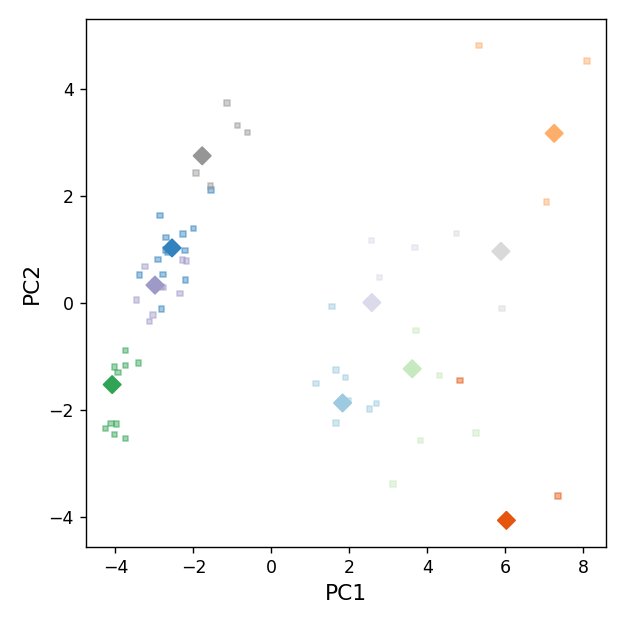

samples nearest to the cluster centers
cluster index  name
   0       17  4-Me-Ph-Me-NH2_boltz 
   1       16  4-F-Ph-NH2_1 
   2       67  pirimidine-NH2_1 
   3       41  2-NH2-benzophenone_boltz 
   4       61  allyl-NH2_1 
   5        9  3_5-diCl-Ph-NH2_1 
   6       65  diPh-CH-NH2_boltz 
   7       19  4-OMe-Ph-NH2_1 
   8       39  2-diPh-1-NH2-Et_boltz 
   9       50  4-CO2Me-Ph-NH2_1 


Samples that each cluster contains (names of the samples as read from Excel)

0 2-Cl-Ph-Et-NH2_boltz;2-Me-Ph-Et-NH2_boltz;2-Me-Ph-Me-NH2_1;2_6-diMe-Ph-Me-NH2_1;4-CF3-Ph-Me-NH2_boltz;4-Cl-Ph-Me-NH2_Boltz;4-F-Ph-Me-NH2_boltz;4-Me-Ph-Me-NH2_boltz;5_3-diMe-Ph-Me-NH2_boltz;Fused-Cycle5-Ph-NH2_1;He-NH2_1;Ph-Et-NH2_boltz;3-N-diMe-1-Pr-NH2_boltz;4-diEtacetal-1-bu-NH2_boltz

1 2-Cl-Ph-NH2_1;2-Me-Ph-NH2_1;3_5-diMe-Ph-NH2_boltz;4-Cl-Ph-NH2_1;4-F-Ph-NH2_1;4-Me-Ph-NH2_1;Ph-NH2_1;2-NH2-biphenyl_1;3-NH2-py_1

2 Br-pirimidine-NH2_1;diCl-pirimidine-NH2_1;pirimidine-NH2_1

3 2-CN-4-Br-Ph-NH2_1;2-NH2-benzophenone

In [117]:
############################################
nclusters = 10 # how many clusters do you want
##########################################

X_kmeans = X_all_pca
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(X_kmeans)
# for i in kmeans.labels_:
#     print(i)
#print(kmeans.cluster_centers_)

dists = []
for comp in range(len(X_kmeans)):
    delta = [X_kmeans[comp,i]-kmeans.cluster_centers_[kmeans.labels_[comp],i] for i in range(len(X_kmeans[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)

clusters = {}
clusters_inv = {}
clusterdists = {}
clustermins = []
for cluster in range(nclusters):
    clusters[cluster] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == cluster]
    clusterdists[cluster] = [dists[i] for i in clusters[cluster]]
    clustermins.append(clusters[cluster][clusterdists[cluster].index(min(clusterdists[cluster]))])

# plot using first two PC
f_ind_1 = 0
f_ind_2 = 1

x_min, x_max = X_kmeans[:, f_ind_1].min() - .5, X_kmeans[:, f_ind_1].max() + .5
y_min, y_max = X_kmeans[:, f_ind_2].min() - .5, X_kmeans[:, f_ind_2].max() + .5

plt.figure(figsize=(5,5))
extent = [x_min,x_max,y_min,y_max]

mapping = kmeans.labels_
#discrete color scheme
cMap = "tab20c"

plt.scatter(X_kmeans[:,f_ind_1], X_kmeans[:,f_ind_2],c=mapping,cmap=cMap,alpha=0.45,marker="s",s=10) 
plt.scatter(X_kmeans[clustermins,f_ind_1],  X_kmeans[clustermins,f_ind_2],c=range(nclusters),cmap=cMap,alpha=1,marker="D",s=50) 

# Legend for color scheme: adapt cbar_names - this example was for another coloring scheme
# cbar_names = ["P[C]$_3$","P[C]$_n$[O]$_m$","P[O]$_3$","P[O]$_2$[N]","P[O][N]$_2$","P[N]$_3$","P[C]$_n$[N]$_m$","P[C]$_n$[B,F,Si,S]$_m$"]
# formatter = plt.FuncFormatter(lambda val,loc:cbar_names[val])
# cbar = plt.colorbar(ticks=[i for i in range(len(set(mapping)))],format=formatter)
# cbar.ax.tick_params(labelsize=10) 
# plt.clim(-0.5,len(cbar_names)-0.5)

plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.xlabel(r"PC1",fontsize=12.5)
plt.ylabel(r"PC2",fontsize=12.5)
plt.locator_params(axis='y', nbins=8)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.tight_layout()
# plt.savefig("190620_PCspace_1.png",dpi=300)
plt.show()     

print('samples nearest to the cluster centers')
print("cluster index  name")
for i,j in enumerate(y_labels_comp[clustermins]):
    print(f"{i:4d}  {clustermins[i]:7d}  {j} ")
    
# print('\n\nSamples that each cluster contains (index of the samples as read from Excel, starting at 0)\n')
# for i in clusters.keys():
#     print(i,clusters[i])
#     print("")

print('\n\nSamples that each cluster contains (names of the samples as read from Excel)\n')
for i in clusters.keys():
    print(i,";".join(y_labels[clusters[i]]))
    print("")        
        
print('\n\nCluster for each sample and distance to the corresponding cluster center\n')
print(" index  cluster  dist   name")
for i,j in enumerate(y_labels):
    print(f"{i:6d}  {kmeans.labels_[i]:4d}  {dists[i]:8.3f}  {j}")



<IPython.core.display.Javascript object>


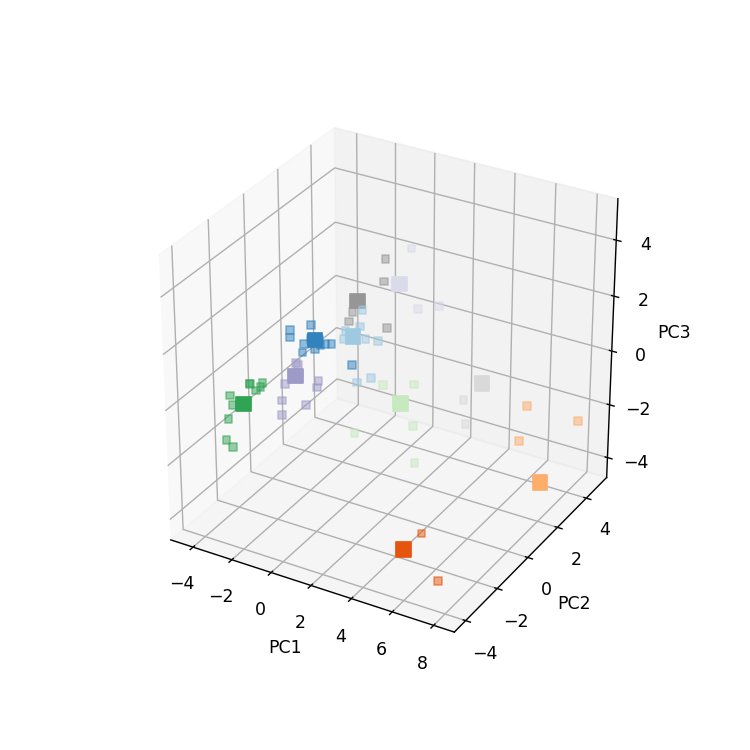

In [115]:
%matplotlib notebook

# Plot in first 3 PC

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import# Fixing random state for reproducibility

np.random.seed(19680801)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_all_pca[:,0],X_all_pca[:,1],X_all_pca[:,2], marker="s",s=20,alpha=0.5,c=mapping,cmap=cMap,)
ax.scatter(X_all_pca[clustermins,0],X_all_pca[clustermins,1],X_all_pca[clustermins,2],c=range(nclusters), marker="s",s=70,alpha=1,cmap=cMap,)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# Colorcode PC plot by descriptor

<IPython.core.display.Javascript object>


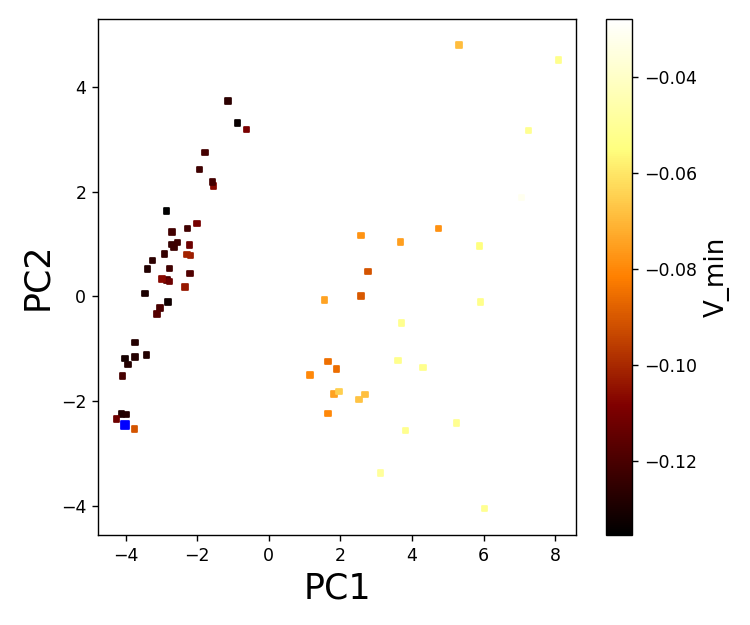

In [123]:
############################################
# PC plot: which principal components are plotted (start at 1)
f_ind_1 = 1 
f_ind_2 = 2

# color-code the plot by which property:(0-indexed)
prop = 24

# more optional adjustments further down
##########################################

f_ind_1,f_ind_2 = f_ind_1-1,f_ind_2-1 # change numbers to 0-indexed

x_min, x_max = X_all_pca[:, f_ind_1].min() - .5, X_all_pca[:, f_ind_1].max() + .5
y_min, y_max = X_all_pca[:, f_ind_2].min() - .5, X_all_pca[:, f_ind_2].max() + .5

plt.figure(figsize=(6,5))
extent = [x_min,x_max,y_min,y_max]

#mapping = [min([i,0]) for i in X_all[:,0]] # optional capping (at 0)
mapping = X_all[:,prop] # 
from matplotlib.colors import ListedColormap
cMap = "afmhot"

plt.scatter(X_all_pca[:,f_ind_1], X_all_pca[:,f_ind_2],c=mapping,cmap=cMap,alpha=1,marker="s",s=10) 
cbar = plt.colorbar()
cbar.set_label(f'{X_names[prop]}', rotation=90,size=15)

############################################
# Highlight individual samples
# uncomment and add more as needed
# adjust the 0-indexed number of the sample two times per line 

sample1 = 69
plt.scatter(X_all_pca[sample1,f_ind_1], X_all_pca[sample1,f_ind_2],c="blue",alpha=1,marker="s",s=20) 

# sample2 = 40
# plt.scatter(X_all_pca[sample2,f_ind_1], X_all_pca[sample2,f_ind_2],c="green",alpha=1,marker="s",s=20) 
##########################################


plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.xlabel(f"PC{f_ind_1+1}",fontsize=20)
plt.ylabel(f"PC{f_ind_2+1}",fontsize=20)
plt.locator_params(axis='y', nbins=8)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.tight_layout()
plt.show()  
# plt.savefig("190620_PCspace_Vmin_1.png",dpi=300)

# Neighbor analysis

In [126]:
############################################
query = "CF3-Me-NH2" # find neighbors of this sample. You can give either the name or index of the sample
n_neighbors = 10 # how many neighbor samples to look up
use_space = "PCA" # can be "PCA" or "descriptors" to choose in which feature space to look for neighbors
##########################################

if use_space == "PCA":
    X_neighbors = X_all_pca
elif use_space == "descriptors":
    X_neighbors = X_all_sc

nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute').fit(X_neighbors)## (n_neighbors=??) how many the neighbours
distances, indices = nbrs.kneighbors(X_neighbors)

if type(query) == str:
    q_id = np.where(y_labels == query)[0][0]
elif type(query) == int:
    q_id = query

q_nbrs = indices[np.where(y_labels == query)][0]
q_nbrs_label = [y_labels[i] for i in q_nbrs]

print("       dist  name")
for i in range(1,len(q_nbrs)):
    print(f"{i:3d} {distances[np.where(y_labels == query)][0][i]:7.3f}  {q_nbrs_label[i]}")


       dist  name
  1   0.549  Proparg-NH2_1
  2   0.992  tBuNH2_1
  3   1.399  iPr-NH2_boltz
  4   1.462  allyl-NH2_1
  5   1.738  Et-NH2_boltz
  6   1.945  2-NH2-pen_boltz
  7   2.080  OMe-CH2-CH2-NH2_boltz
  8   2.086  Cycle5-NH2_1
  9   2.137  4-hep-NH2_boltz
